# Experimental Concerns for Beam Measurement

**Scott Prahl**

**Sept 2023**

Many mistakes can be made when making a beam measurement.  This notebook collects a number of these.

The ISO 11146 standard recommends masking the image with a rotated rectangular mask around the center of the image.  This notebook explains how that was implemented and then shows some results for artifically generated images of non-circular Gaussian beams. As noise increases, the first-order parameters (beam center) are robust, but the second-order parameters (diameters) are shown to be much more sensitive to image noise.


In [1]:
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import laserbeamsize as lbs

pixel_size_µm = 3.75               # microns
repo = "https://github.com/scottprahl/laserbeamsize/raw/master/docs/"

## Image of beam is saturated

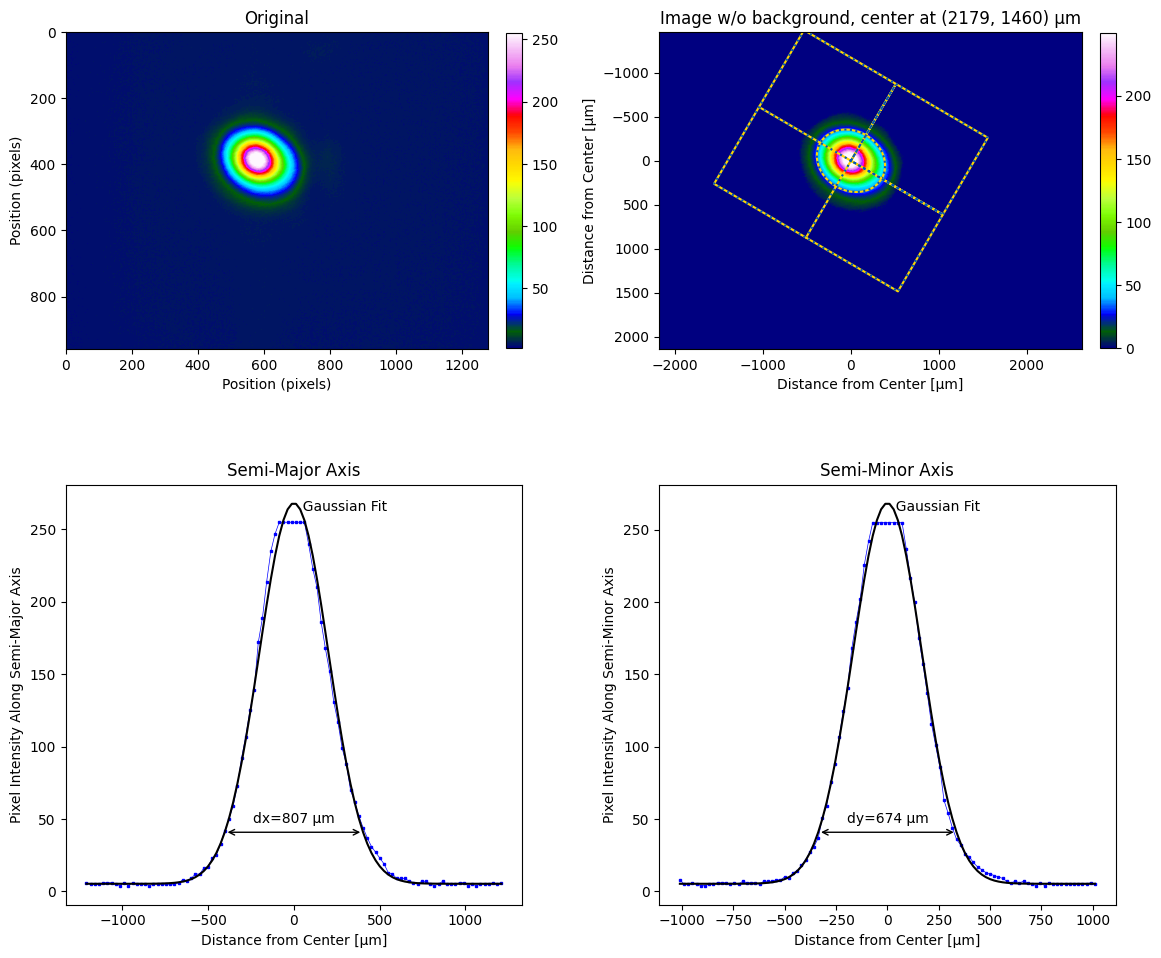

In [2]:
sat_img = iio.imread(repo + "k-200mm.png")
lbs.beam_size_plot(sat_img, pixel_size=pixel_size_µm)

## Image of beam is too small

## Image of beam is too large

## Image of beam is too close to margins

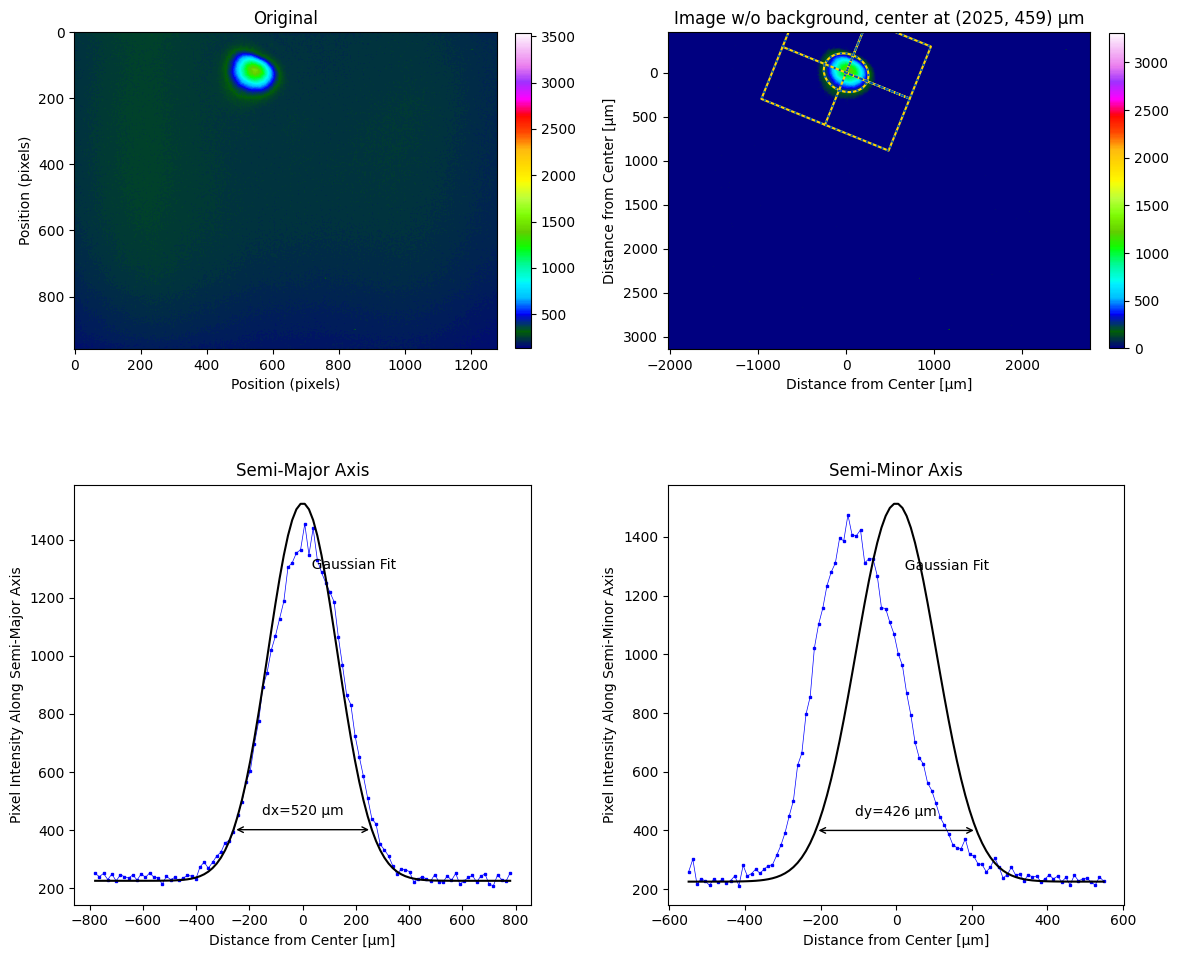

In [3]:
margin_img = iio.imread(repo+"TEM00_300mm.pgm")>>4

options = {'pixel_size': pixel_size_µm, 'units': "µm"}
lbs.beam_size_plot(margin_img, **options)

## Image has artifacts, example 1

With the standard color map it is not obvious why the vertical dimension is nuts.

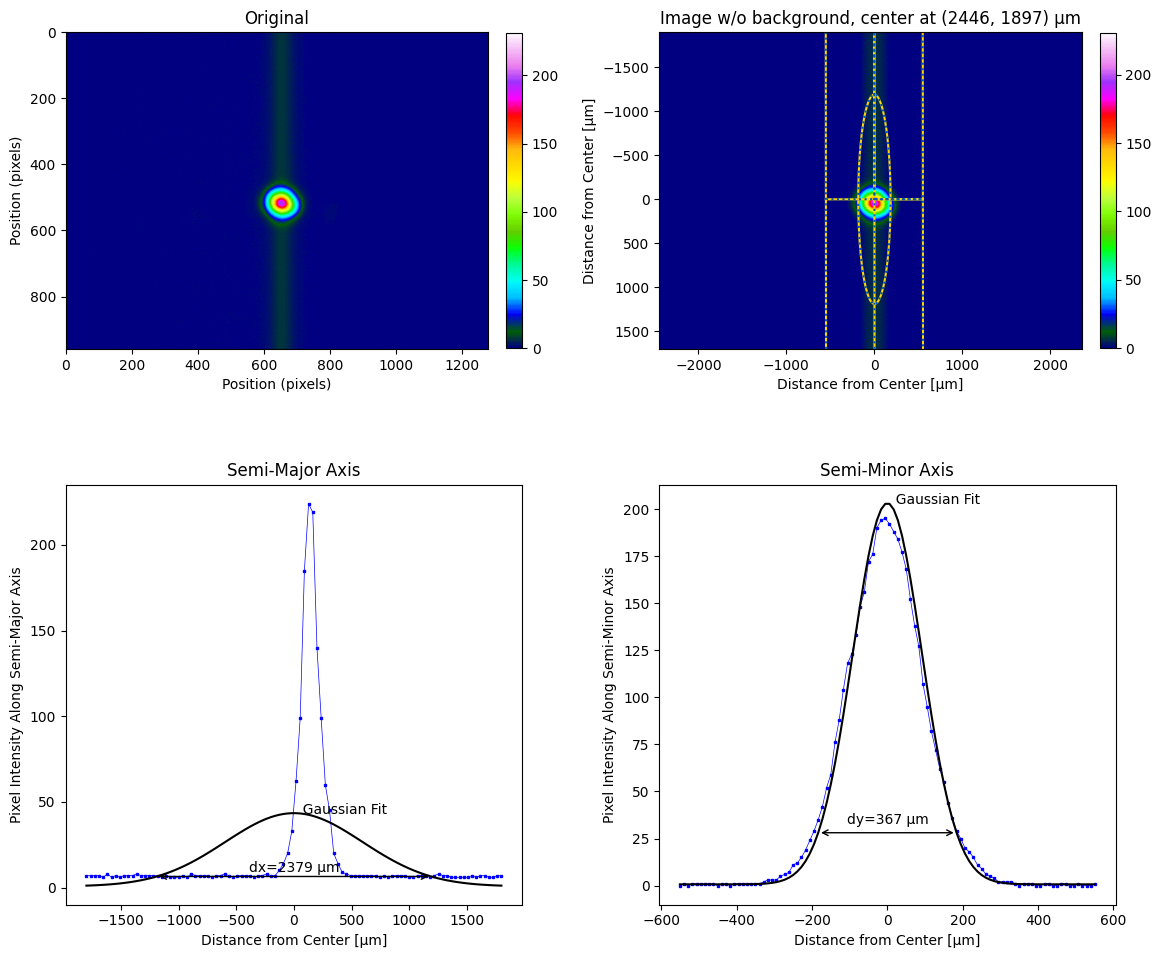

In [4]:
art1_img = iio.imread(repo+"TEM00_150mm.pgm")

options = {'pixel_size': pixel_size_µm, 'units': "µm"}
lbs.beam_size_plot(art1_img, **options)

Cropping the beam allows a reasonable fit to be obtained.  However, in the image on the top right below, the integration rectangle extends beyond the image.  Thus the result is not ISO 11146 compliant.

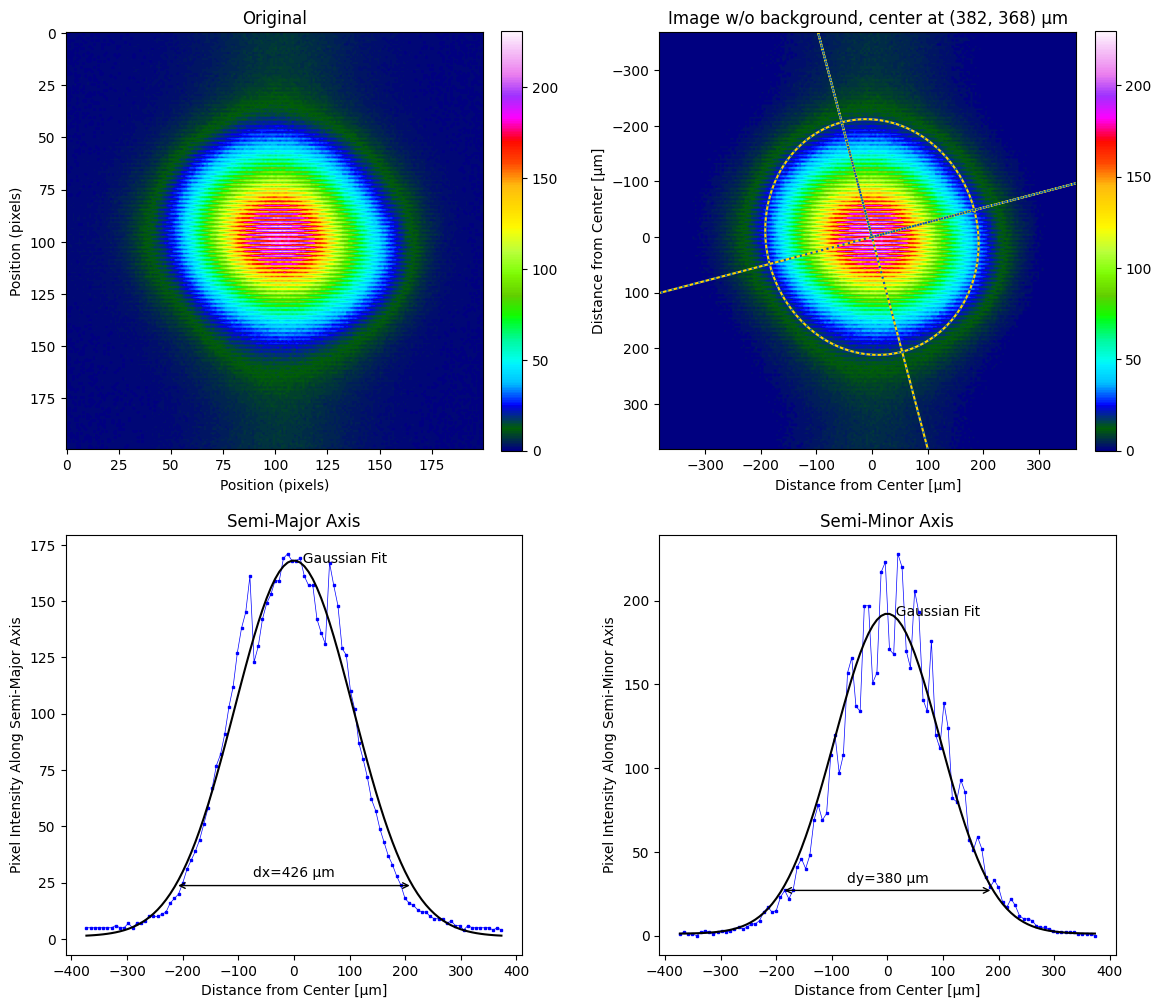

In [5]:
lbs.beam_size_plot(art1_img[420:620,550:750], **options, cmap='gist_ncar')

## Image has artifacts, 2

Here a small artifact above the primary beam image (perhaps a reflection) dramatically changes the vertical beam diameter.

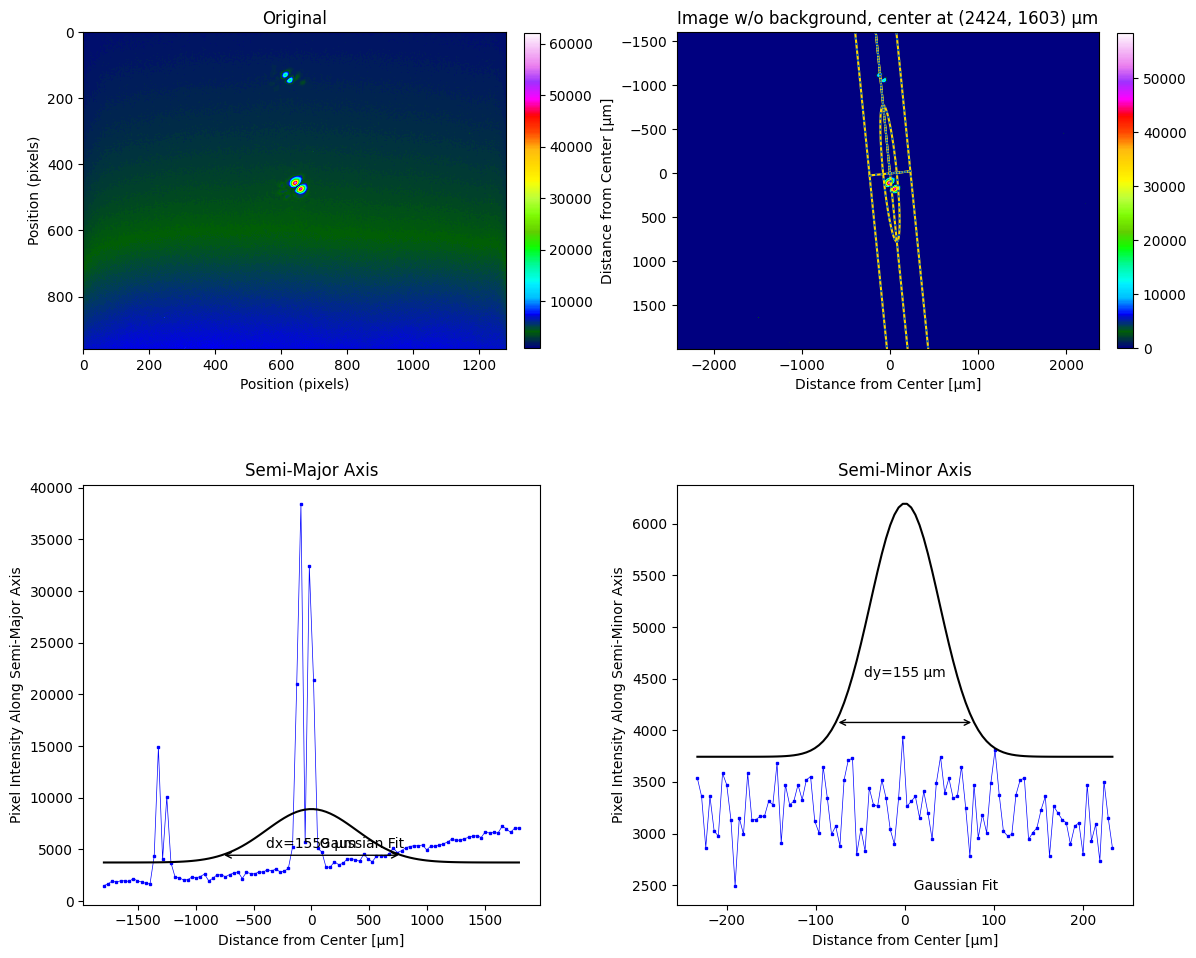

In [6]:
art2_img = iio.imread(repo+"sb_259mm_10.pgm")
lbs.beam_size_plot(art2_img, pixel_size=pixel_size_µm,cmap='gist_ncar')

Cropping the image produces much more reasonable values for the diameters.

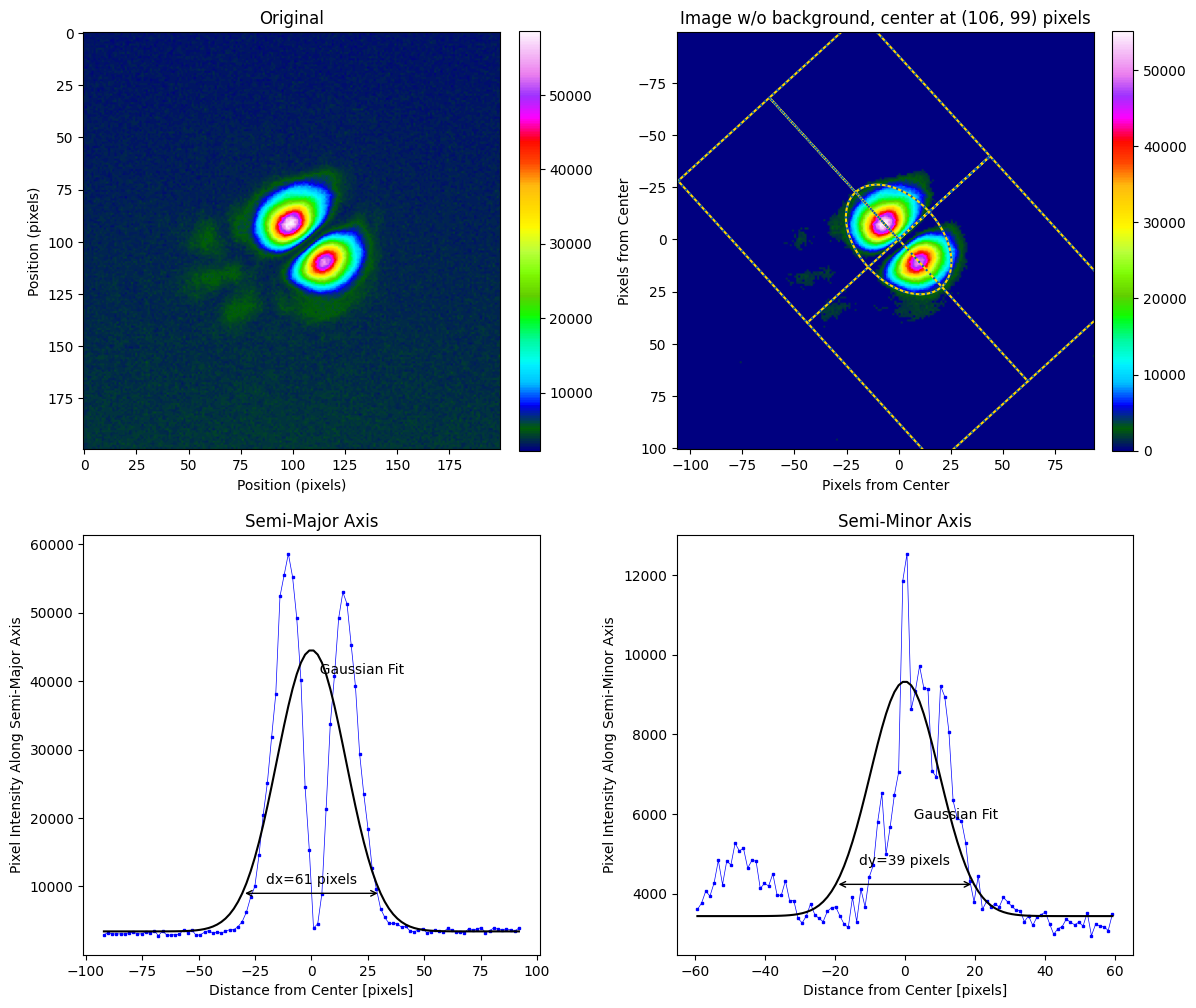

In [7]:
lbs.beam_size_plot(art2_img[365:565,543:743])

## Image of beam has too much noise

The background is nearly half of the central beam intensity.  Although subtracting the background kind of worked, the offset affects the fitted gaussian and makes the diameter too wide.

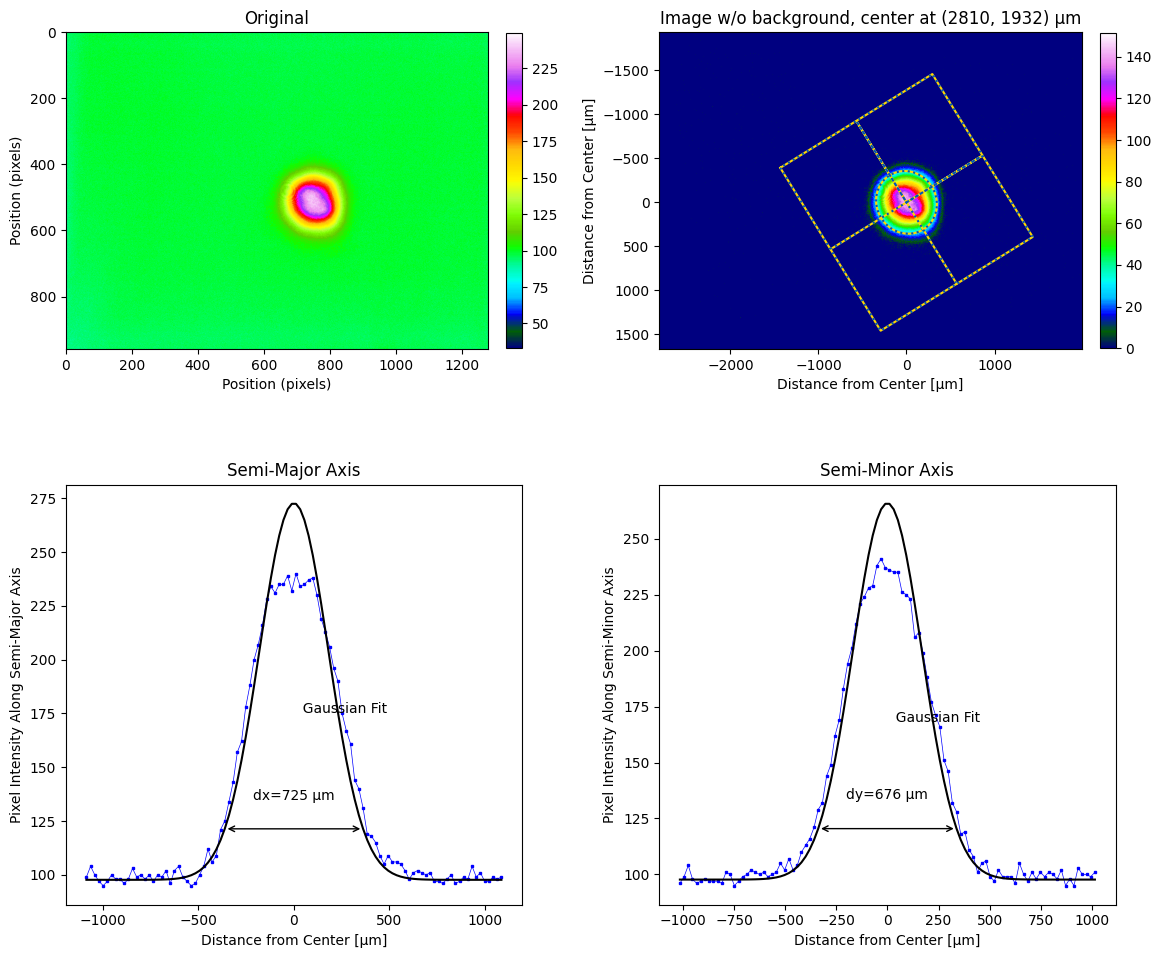

In [8]:
noise_img = iio.imread(repo+"k-800mm.png")
lbs.beam_size_plot(noise_img, pixel_size=pixel_size_µm)